In [16]:
from HeaderP import *
from __future__ import print_function
import numpy as np
import os
import scipy.io
import os.path as path
import pylab
import matplotlib
import struct
import time
import h5py
#import loaders
import sys
#from const import *
from math import *

In [17]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

In [3]:
f1 = h5py.File('snapshot_reduced_halo_6_063.hdf5')

In [4]:
f1['PartType4'].keys()

<KeysViewHDF5 ['AccretedFlag', 'BirthPos', 'BirthVel', 'Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_Metals', 'GFM_StellarFormationTime', 'GFM_StellarPhotometrics', 'GravForce', 'GravPotential', 'Masses', 'ParticleIDs', 'Velocities']>

In [5]:
O = f1['PartType4']['GFM_Metals'][:,4]
Mg = f1['PartType4']['GFM_Metals'][:,6]
Si = f1['PartType4']['GFM_Metals'][:,7]

fe = f1['PartType4']['GFM_Metals'][:,8]
h = f1['PartType4']['GFM_Metals'][:,0]

<ipython-input-6-87a1581812d8>:3: RuntimeWarning: divide by zero encountered in log10
  feh = np.log10(fe[m]/h[m]/56)-(7.54-12)
<ipython-input-6-87a1581812d8>:3: RuntimeWarning: invalid value encountered in log10
  feh = np.log10(fe[m]/h[m]/56)-(7.54-12)
<ipython-input-6-87a1581812d8>:4: RuntimeWarning: divide by zero encountered in log10
  mgh = np.log10(Mg[m]/h[m]/24)-(7.64-12)
<ipython-input-6-87a1581812d8>:4: RuntimeWarning: invalid value encountered in log10
  mgh = np.log10(Mg[m]/h[m]/24)-(7.64-12)
<ipython-input-6-87a1581812d8>:5: RuntimeWarning: divide by zero encountered in log10
  oh = np.log10(O[m]/h[m]/16)-(8.73-12)
<ipython-input-6-87a1581812d8>:5: RuntimeWarning: invalid value encountered in log10
  oh = np.log10(O[m]/h[m]/16)-(8.73-12)
<ipython-input-6-87a1581812d8>:6: RuntimeWarning: divide by zero encountered in log10
  sih = np.log10(Si[m]/h[m]/28)-(7.55-12)
<ipython-input-6-87a1581812d8>:6: RuntimeWarning: invalid value encountered in log10
  sih = np.log10(Si[m]/h[m

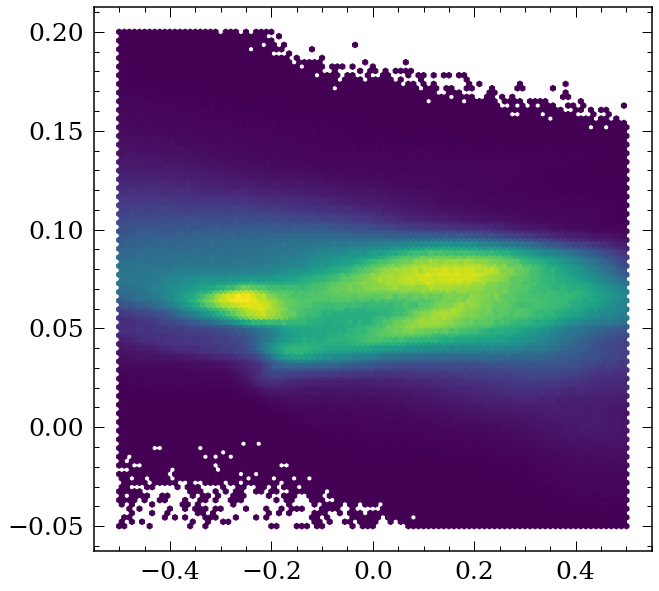

In [6]:
#m = (fe>0)&(Mg>0)&(O>0)&(Si>0)
m = np.array(np.ones(len(fe)), dtype=bool)
feh = np.log10(fe[m]/h[m]/56)-(7.54-12)
mgh = np.log10(Mg[m]/h[m]/24)-(7.64-12)
oh = np.log10(O[m]/h[m]/16)-(8.73-12)
sih = np.log10(Si[m]/h[m]/28)-(7.55-12)

ah = (mgh+oh+sih)/3
afe = ah-feh

plt.hexbin(feh, afe, extent=(-0.5, 0.5, -0.05, 0.2), mincnt=1)



In [7]:
bx = f1['PartType4']['BirthPos'][:,2]*1e3
by = f1['PartType4']['BirthPos'][:,1]*1e3
bz = f1['PartType4']['BirthPos'][:,0]*1e3


x = f1['PartType4']['Coordinates'][:,2]*1e3
y = f1['PartType4']['Coordinates'][:,1]*1e3
z = f1['PartType4']['Coordinates'][:,0]*1e3

age = f1['PartType4']['GFM_StellarFormationTime']

#feh = f1['PartType4']['GFM_Metallicity']

acc = f1['PartType4']['AccretedFlag']

r_bir = np.sqrt(bx**2+by**2)

data = pd.DataFrame(np.array((x,y,z,feh,afe,r_bir,age[:],acc[:])).T, 
                    columns=['x','y','z','feh','afe','R_bir','age','accflag'])

data = data.loc[data['accflag']==-1].reset_index(drop=True)
data['R'] = np.sqrt(data['x']**2+data['y']**2)
data = data.loc[data['age']>=0].reset_index(drop=True)

data = data.loc[data['R_bir']<30]

rscale = 3.5/5.95

data['R'] = data['R']*rscale
data['R_bir'] = data['R_bir']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale
#data['age'] = 13.8-data['age']
#data.to_pickle('Auriga.pkl')

In [8]:
#data.to_pickle('Auriga.pkl')

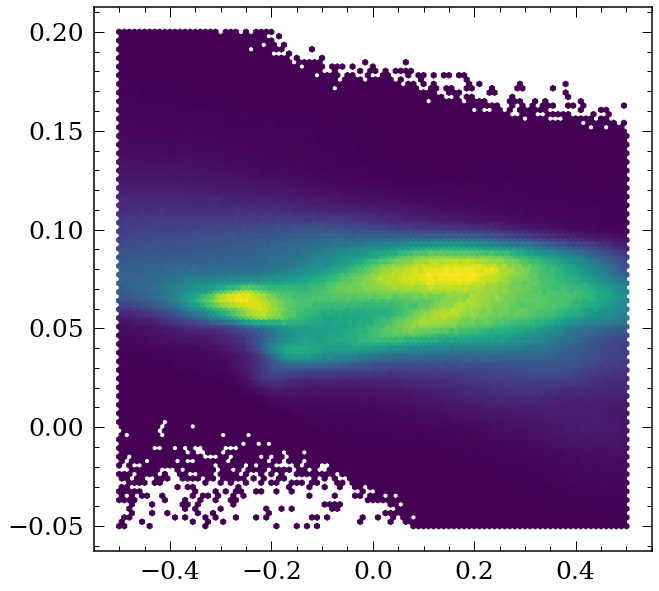

In [9]:
data = pd.read_pickle('Auriga.pkl')
plt.hexbin(data['feh'], data['afe'], extent=(-0.5, 0.5, -0.05, 0.2), mincnt=1)


In [15]:
#m = ((data['age']-10)<0.5)&(((data['feh']+0.4)<0.1))
#plt.hist(data['R'][m],bins=np.linspace(0,10,100))

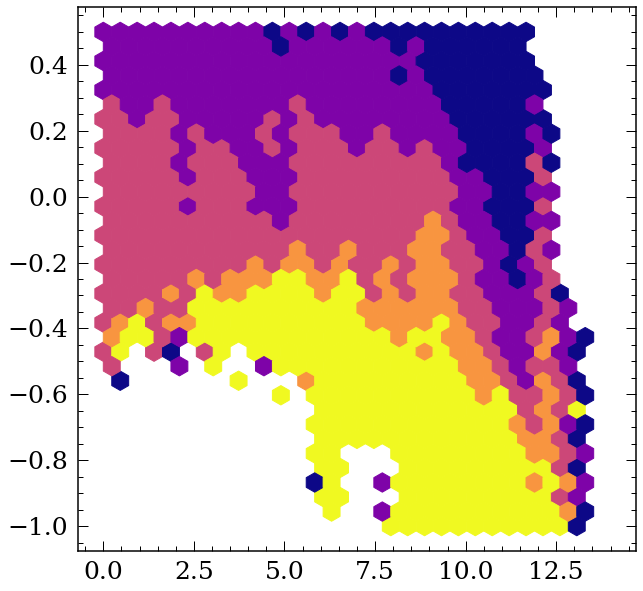

In [10]:

plt.hexbin(data['age'], data['feh'], C=abs(data['R']),
          extent=(0,14,-1,0.5),vmin=0,vmax=5, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',5),
          reduce_C_function=np.std)



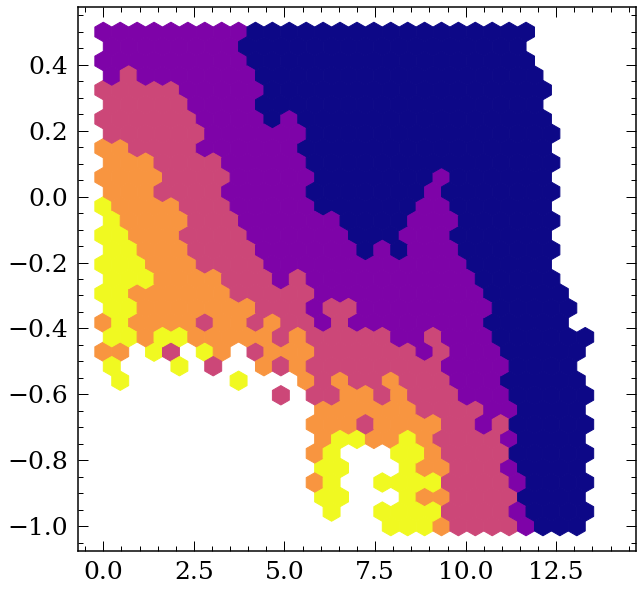

In [11]:
plt.hexbin(data['age'], data['feh'], C=abs(data['R_bir']),
          extent=(0,14,-1,0.5),vmin=0,vmax=15, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',5))



# Check simiulation with a bar

In [305]:
print(len(data))
data = data.loc[data['R_bir']<30]
data = data.loc[data['age']>=0]
data = data.loc[data['accflag']==-1]
print(len(data))

13451531
13451531


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>]], dtype=object)

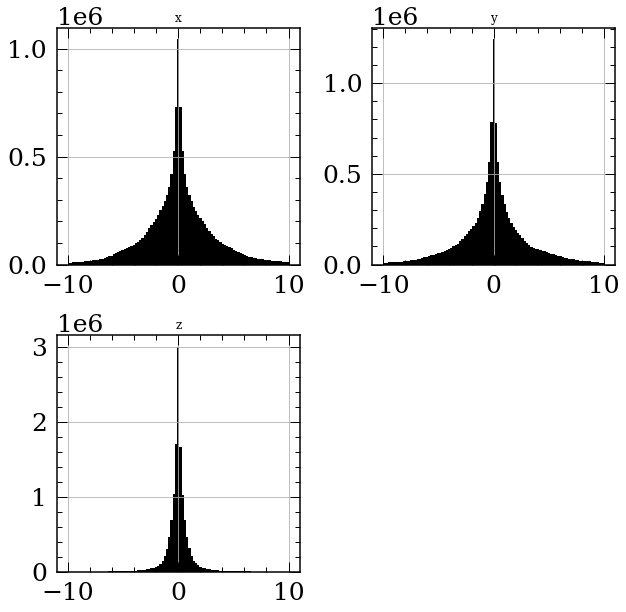

In [306]:

data[['x','y','z']].hist(bins=np.linspace(-10,10,100),
                        color='k')


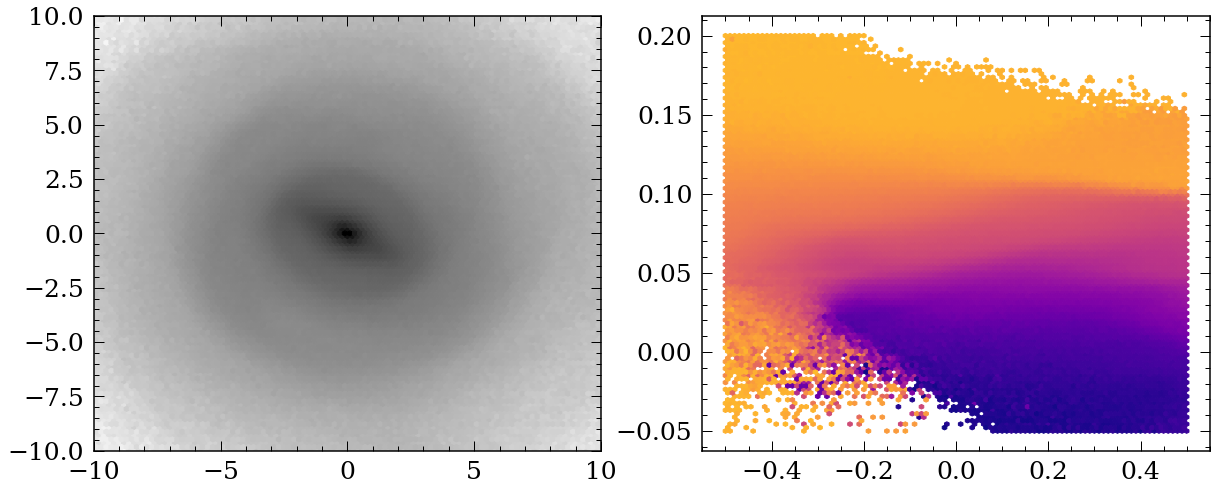

In [307]:

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(data['x'], data['y'], extent=(-10,10,-10,10),
          cmap='binary', bins='log')
plt.xlim([-10,10])
plt.ylim([-10,10])

plt.subplot(1,2,2)
plt.hexbin(data['feh'], data['afe'], C = data['age'],
           extent=(-0.5, 0.5, -0.05, 0.2),
          cmap='plasma', vmin=0, vmax=14)


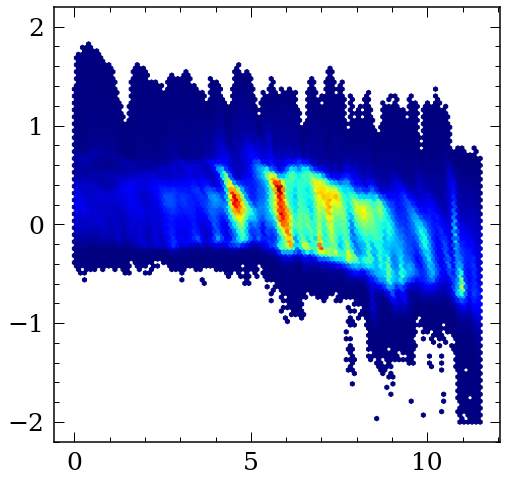

In [344]:
plt.figure(figsize=(8,8))
plt.hexbin(data['age'], data['feh'], extent=(0,11.5,-2,2),
          mincnt=1, cmap='jet')

In [308]:
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        fehmin = np.percentile(feh_sing[m2],5)
        fehmax = np.percentile(feh_sing[m2],95)
        
        #fehmin = min(feh_sing[m2])
        #fehmax = max(feh_sing[m2])
        #fehscatter[i] = fehmax-fehmin
        
        #fehscatter[i] = np.std(feh_sing[m2])
        #fehmin = np.mean(feh_sing[m2])-fehscatter[i]
        #fehmax = np.mean(feh_sing[m2])+fehscatter[i]

        
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmax, 'b-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmin, 'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            
            
            
            
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter

"""def monoage_line_range_med(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        
        r_sing, feh_sing = r_sing[m2], feh_sing[m2]
        
        mov_r, mov_feh = movingMed_time(r_sing, feh_sing, 0.1, 0.5) 
        movint = interp1d(mov_r, mov_feh)
        
        m2 = (r_sing>min(mov_r))&(r_sing<max(mov_r))
        
        m3 = (feh_sing[m2]>movint(r_sing[m2]))
        
        fehmin = np.percentile(feh_sing[m2][m3], 80)
        fehmax = np.percentile(feh_sing[m2][~m3], 20)
        fehscatter[i] = fehmax-fehmin
        #fehscatter[i] = np.std(feh_sing[m2])
        
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(mov_r, mov_feh, 'k-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmax, 'b-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmin, 'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            
            
            
            
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter"""

"def monoage_line_range_med(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],\n                feherr=[],checkplt=True):\n    colors = getcolor(range(len(agebin)+1))\n    slopes = np.zeros(len(agebin)-1)\n    fehscatter = np.zeros(len(agebin)-1)\n    \n    plt.figure(figsize=(20,8))\n    for i in trange(len(agebin)-1):\n        m = (age>agebin[i])&(age<agebin[i+1])\n        if sum(m)==0:\n            fehscatter[i] = np.nan\n            continue\n        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))\n        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)\n        \n        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])\n        if sum(m2)==0:\n            fehscatter[i] = np.nan\n            continue\n        \n        r_sing, feh_sing = r_sing[m2], feh_sing[m2]\n        \n        mov_r, mov_feh = movingMed_time(r_sing, feh_sing, 0.1, 0.5) \n        movint = interp1d(mov_r, mov_feh)\n        \n        m2 = (r_sing>min(mov_r))&(r_sing<ma

100%|██████████| 14/14 [00:01<00:00, 10.43it/s]


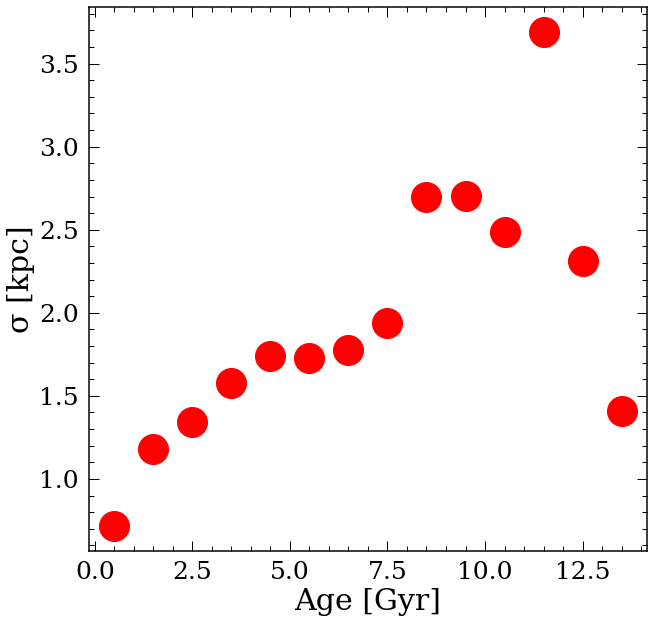

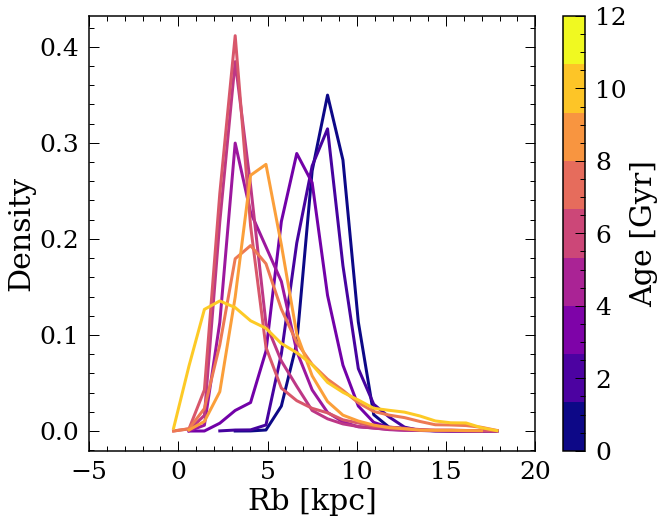

In [322]:
xlims = [7,10]
m = (data['R']>xlims[0])&(data['R']<xlims[1])
m = m&(abs(data['z'])<0.5)
#m = m&((data['ri']>xlims[0])&(data['ri']<xlims[1]))

agebin = np.linspace(0,14,15)
for i in trange(len(agebin)-1):
    m2 = (data[m]['age']>agebin[i])&(data[m]['age']<agebin[i+1])
    data_sing = data[m][m2].dropna()
    plt.plot(agebin[i]/2+agebin[i+1]/2,
             np.std(data_sing['R']-data_sing['R_bir']),'ro', markersize=30)
plt.xlabel('Age [Gyr]')
plt.ylabel('σ [kpc]')


agebin_Rb = np.linspace(0,12,10)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
data_rbdis = data[m]
for i in range(len(agebin_Rb)-1):
    sub_sing = data_rbdis.loc[(data_rbdis['age']>agebin_Rb[i])&(data_rbdis['age']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['R_bir'], 
                            bins=np.linspace(-5,20,30), density=True)
    
    m2 = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m2]/2, fre[m2], color=agebin_colors[i], linewidth=3)
    
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.xlim([-5,20])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')






100%|██████████| 14/14 [00:13<00:00,  1.05it/s]


<Figure size 1440x576 with 0 Axes>

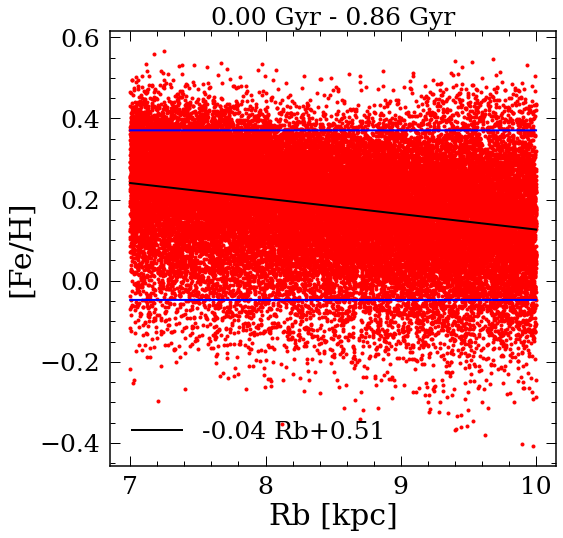

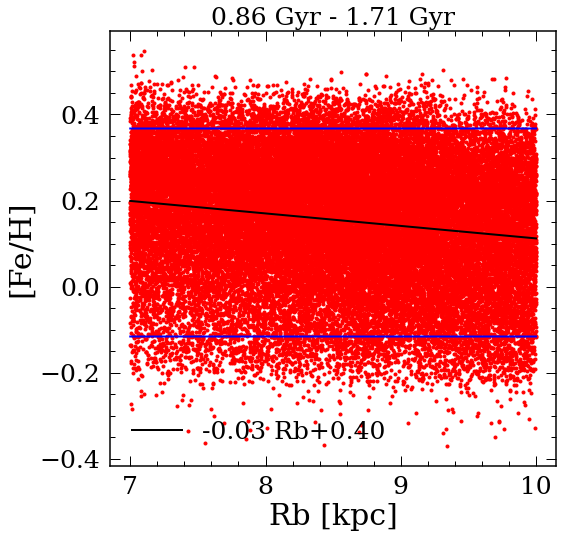

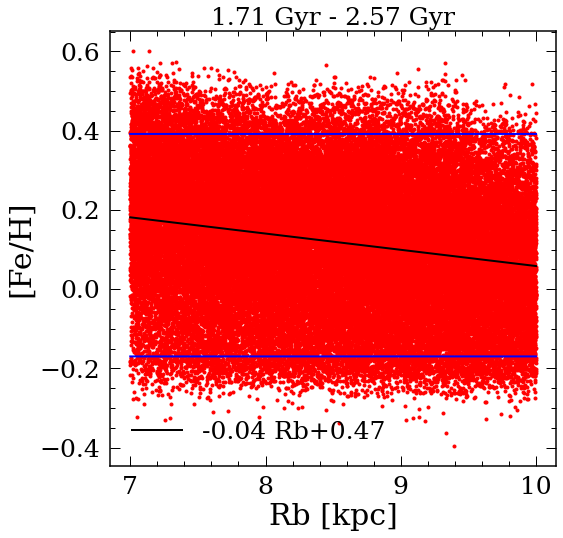

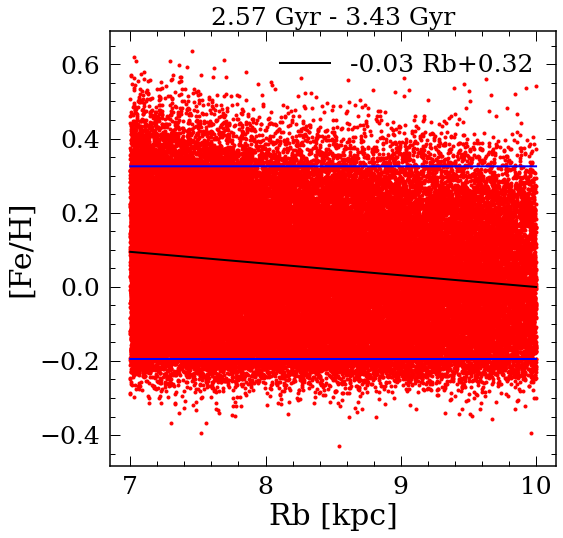

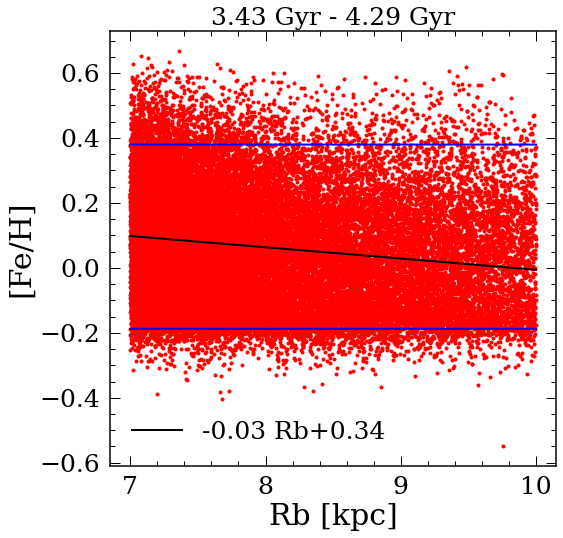

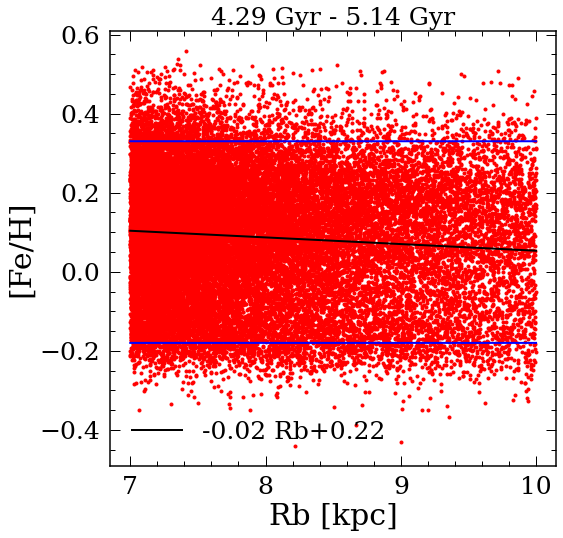

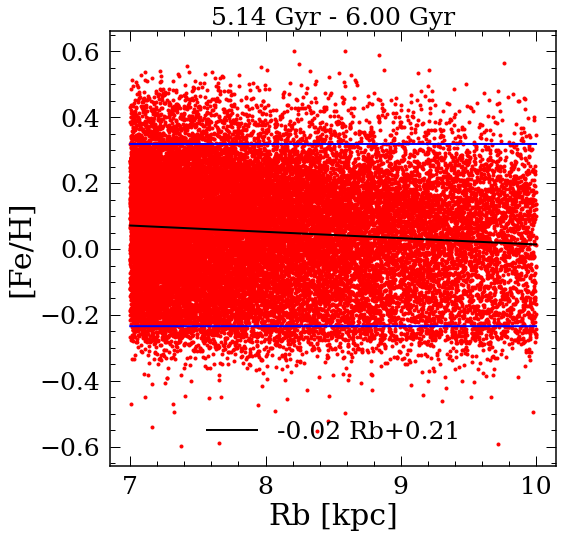

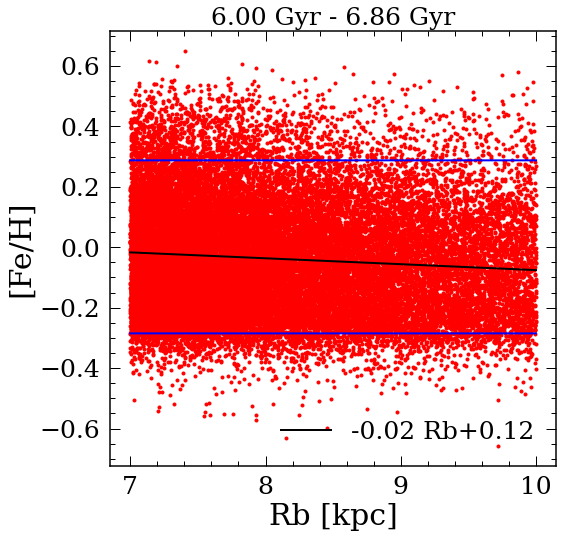

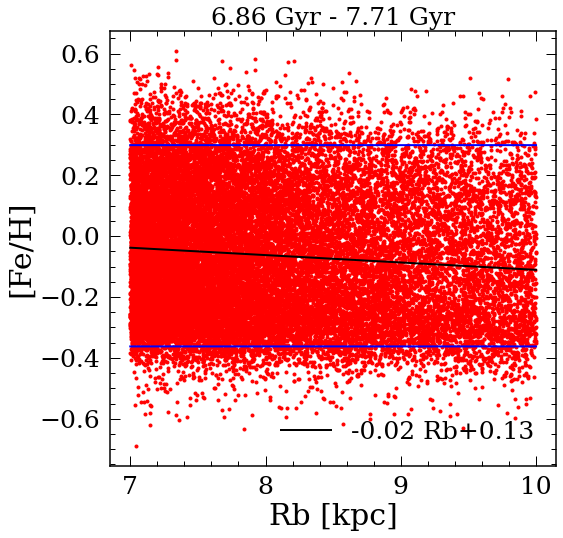

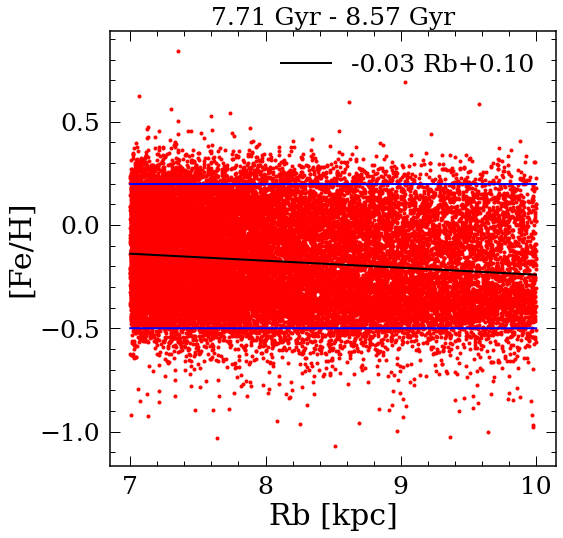

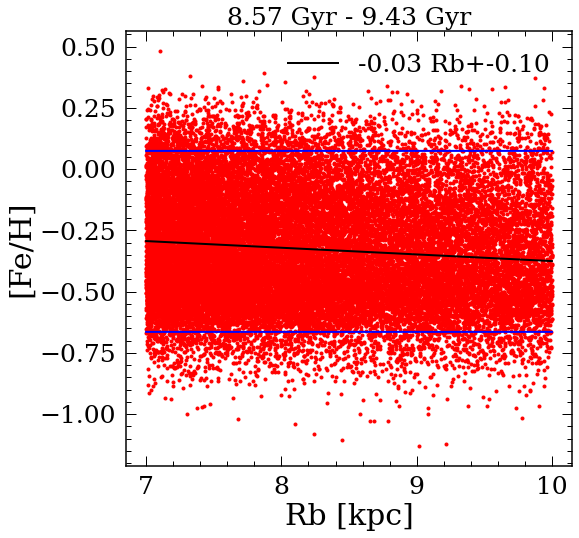

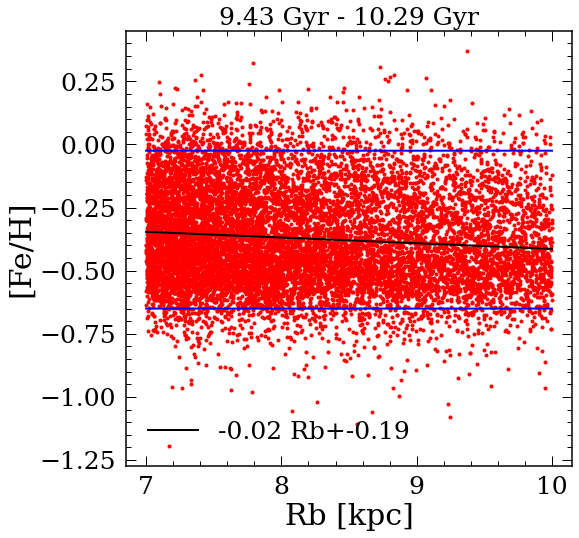

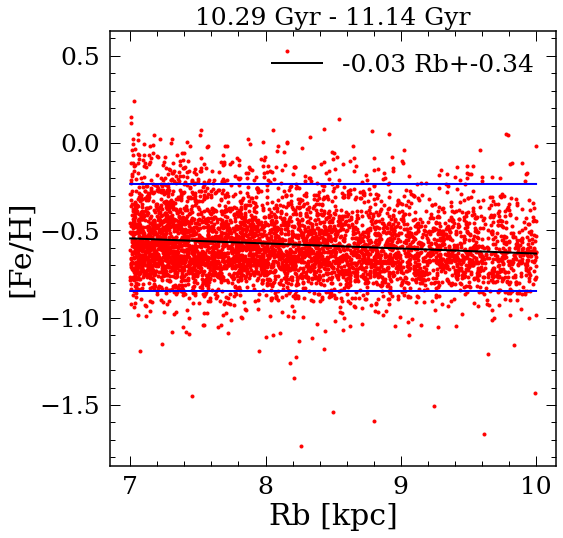

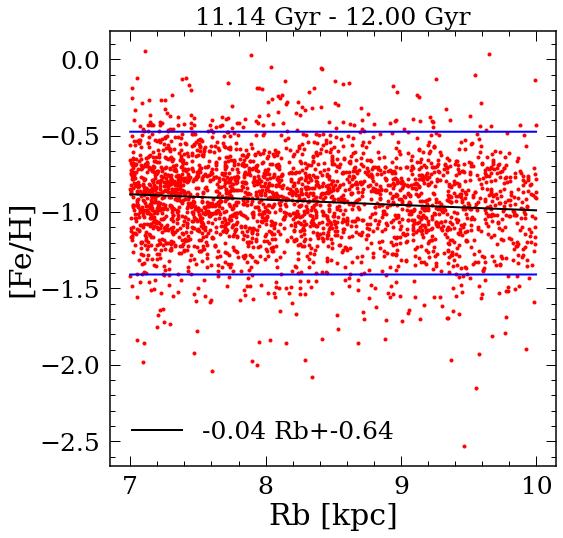

In [315]:
import warnings
warnings.filterwarnings('ignore')


ages, slopes, fehscatter = monoage_line_range(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,12,15),
                                        xlims=[0,25],ylims=[-2,2])



6.408385669483858 2.453952122998165
[3.9544335464856926, 8.862337792482023]


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


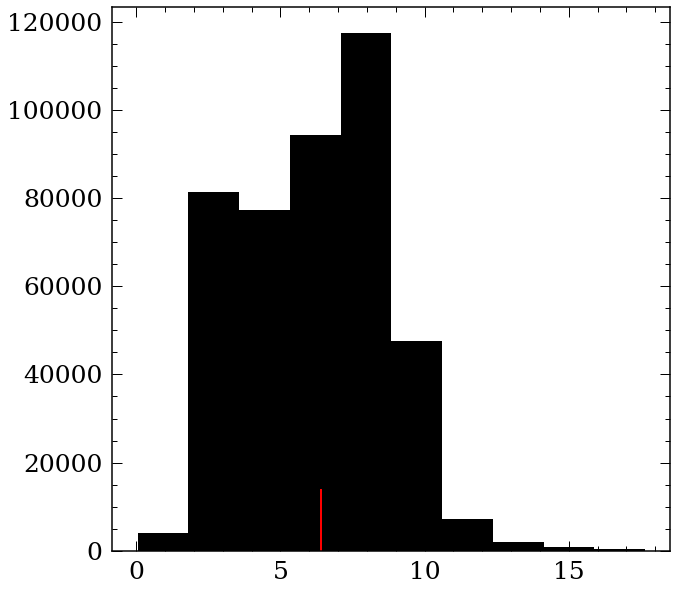

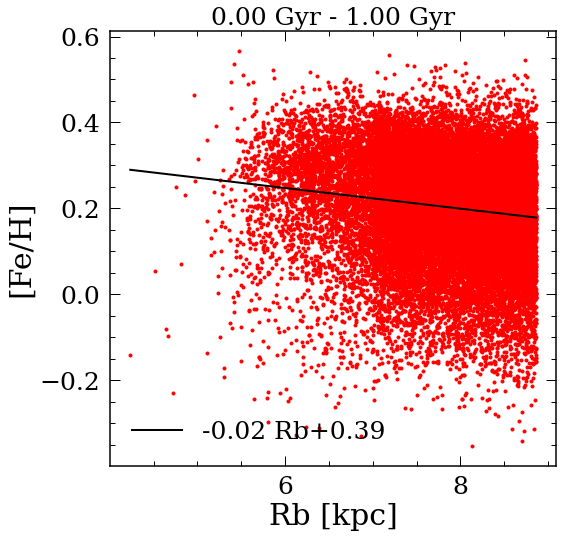

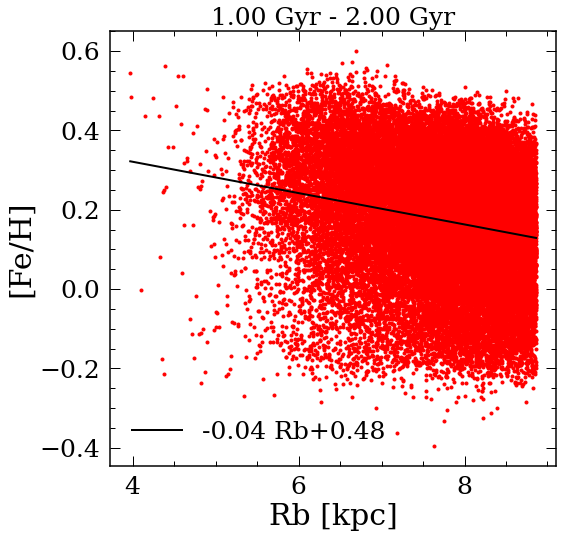

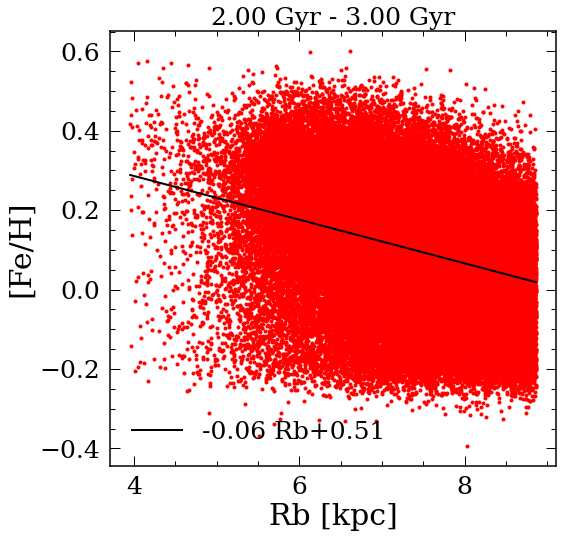

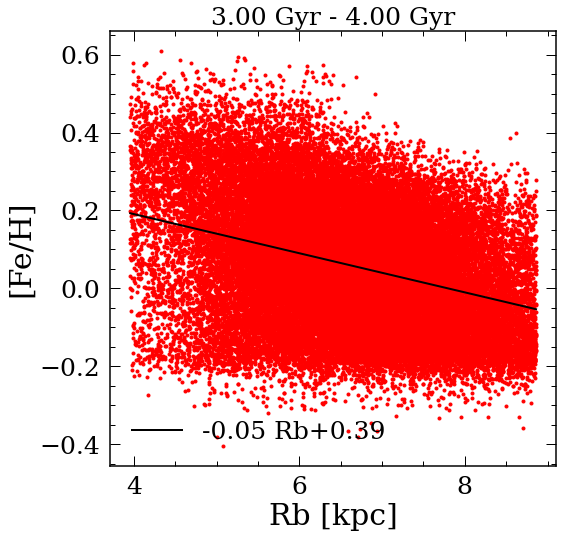

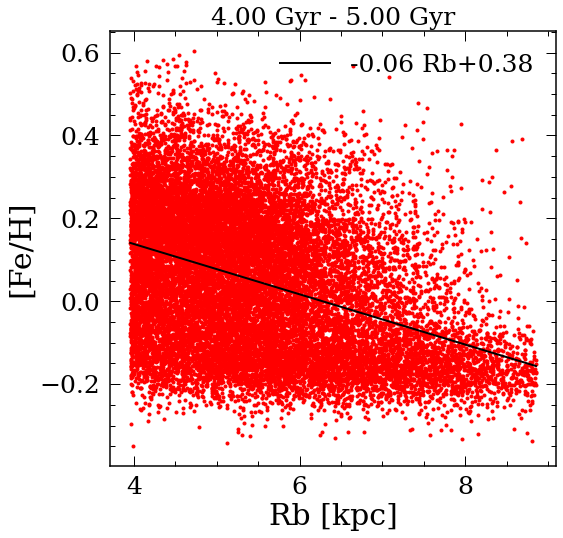

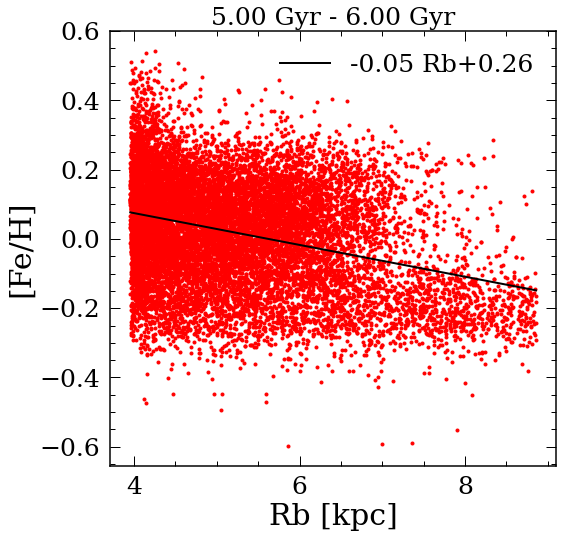

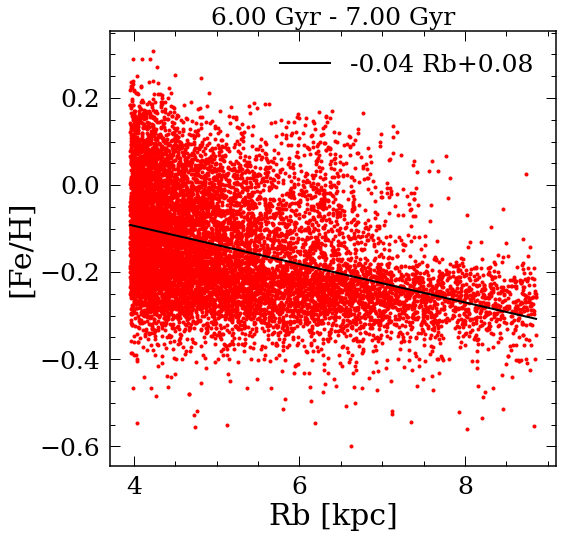

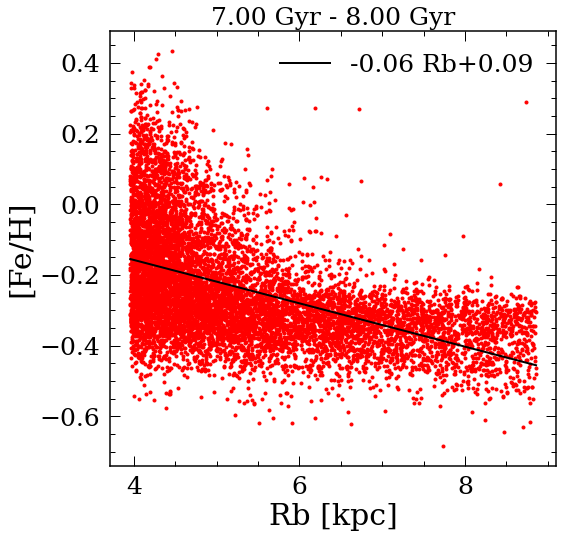

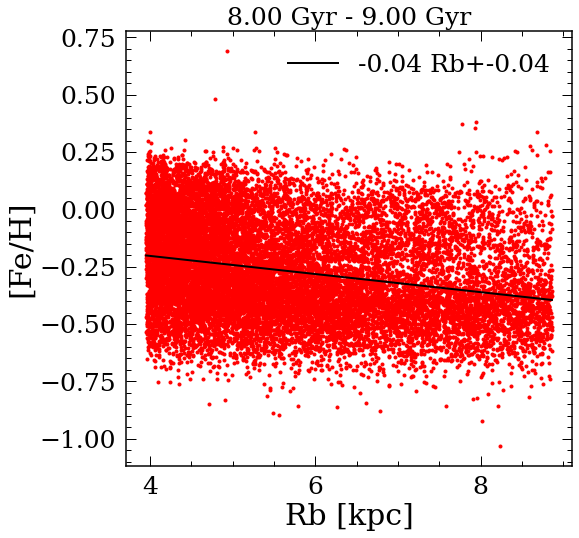

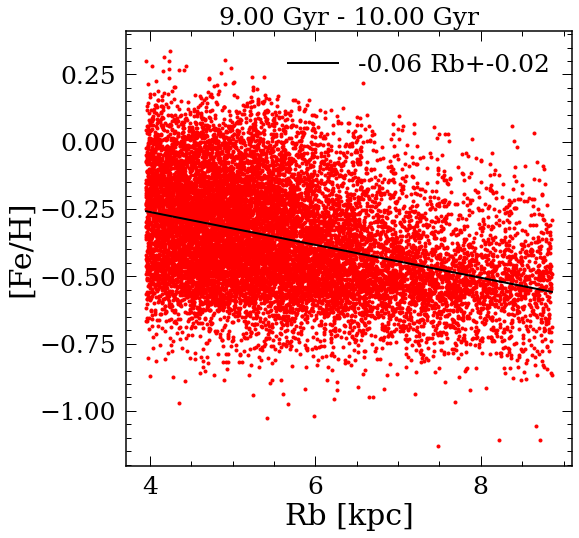

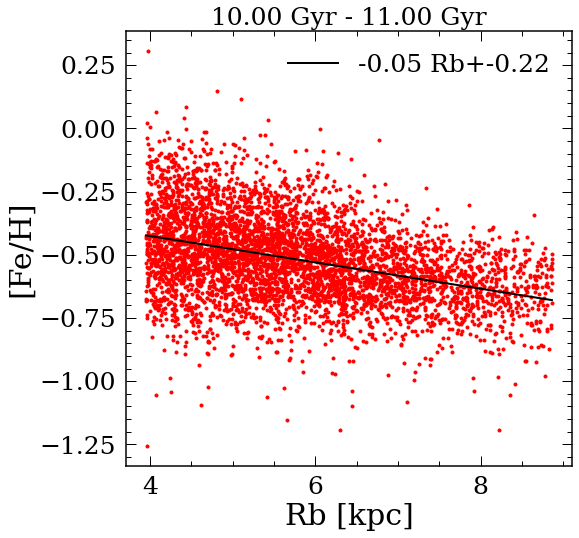

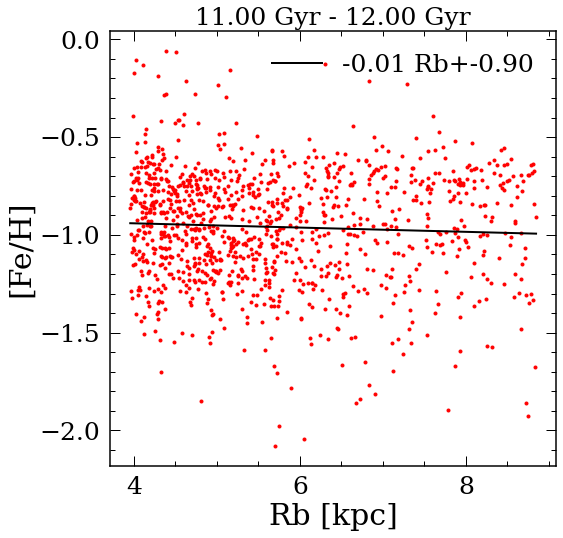

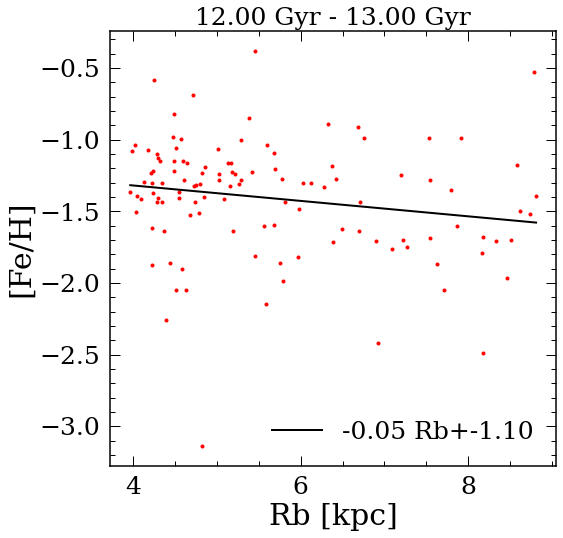

In [324]:
plt.hist(data['R_bir'].values[m], color='k')
plt.vlines(np.median(data['R_bir'].values[m]), ymin=0, ymax=14000, color='r')
print(np.median(data['R_bir'].values[m]), np.std(data['R_bir'].values[m]))

medrb = np.median(data['R_bir'].values[m])
stdrb = np.std(data['R_bir'].values[m])
                  

#xlims = [5,9]
#m = (data['R_bir']>3)&(data['R_bir']<10)
#m = m&(abs(data['z'])<1)
"""xlims = [5,8]
ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['ri'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,12,15),
                                                 xlims=xlims)
"""
xlims = [medrb-stdrb,medrb+stdrb]
#xlims = [7,10]
print(xlims)
ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,15),
                                                 xlims=xlims)



(0.0, 11.5)

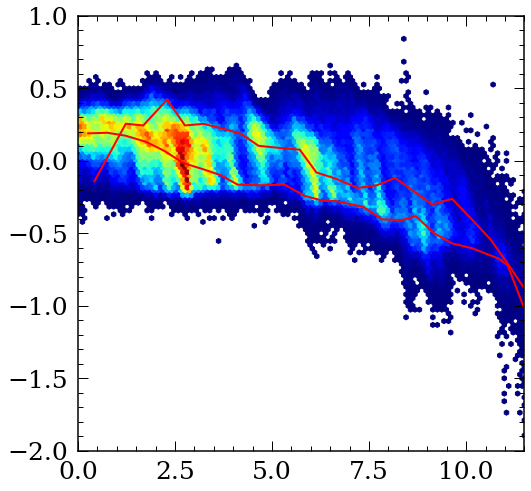

In [325]:
plt.figure(figsize=(8,8))
plt.hexbin(data['age'][m], data['feh'][m], extent=(0,11.5,-2,1),
          mincnt=1, cmap='jet')

data = data.sort_values('age')
"""age, feh = movingMed_time(data['age'][m], data['feh'][m], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r--')

m2 = m&((data['ri']>7.9)&(data['ri']<8.1))
age, feh = movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r-')
"""

m2 = m&(data['R_bir']>xlims[1]-0.5)&(data['R_bir']<xlims[1])
age_outer, feh_outer= movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age_outer!=0)
plt.plot(age_outer[eq], feh_outer[eq], 'r-')

from scipy.interpolate import interp1d
intout = interp1d(age_outer[eq], feh_outer[eq])

m2 = m&(data['R_bir']<xlims[0]+0.5)&(data['R_bir']>xlims[0])
age, feh = movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r-')

intin = interp1d(age[eq], feh[eq])
plt.ylim([-2,1])
plt.xlim([0,11.5])




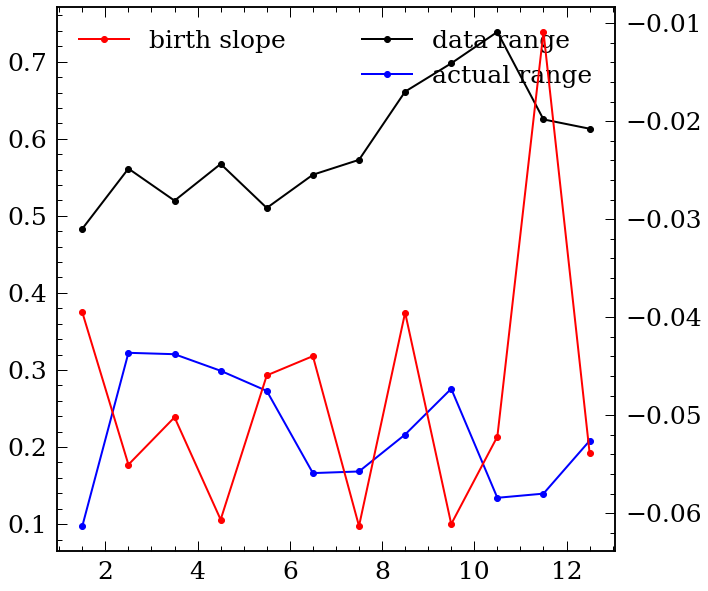

In [339]:
m = (ages>0.5)&(ages<13.5)
plt.plot(ages[m], (fehscatter)[m], 'k-o', label='data range')
plt.plot(ages[m], (intin(ages[m])-intout(ages[m])), 'b-o', label='actual range')
plt.legend(loc=1)
plt.twinx()
plt.plot(ages[m], slopes_rbir[m], 'r-o', label='birth slope')
plt.legend(loc=2)

In [340]:
#m = (ages<7)
#plt.plot((intin(ages[m])-intout(ages[m])-fehscatter[m]), 'ko')
#plt.plot((intin(ages[m])-intout(ages[m])-fehscatter[m])*np.exp(0.4*ages[m]), 'ro')

((-0.47477119511052, 0.11884206937775438),
 (-0.05116025399931643, 0.8745361557795193))

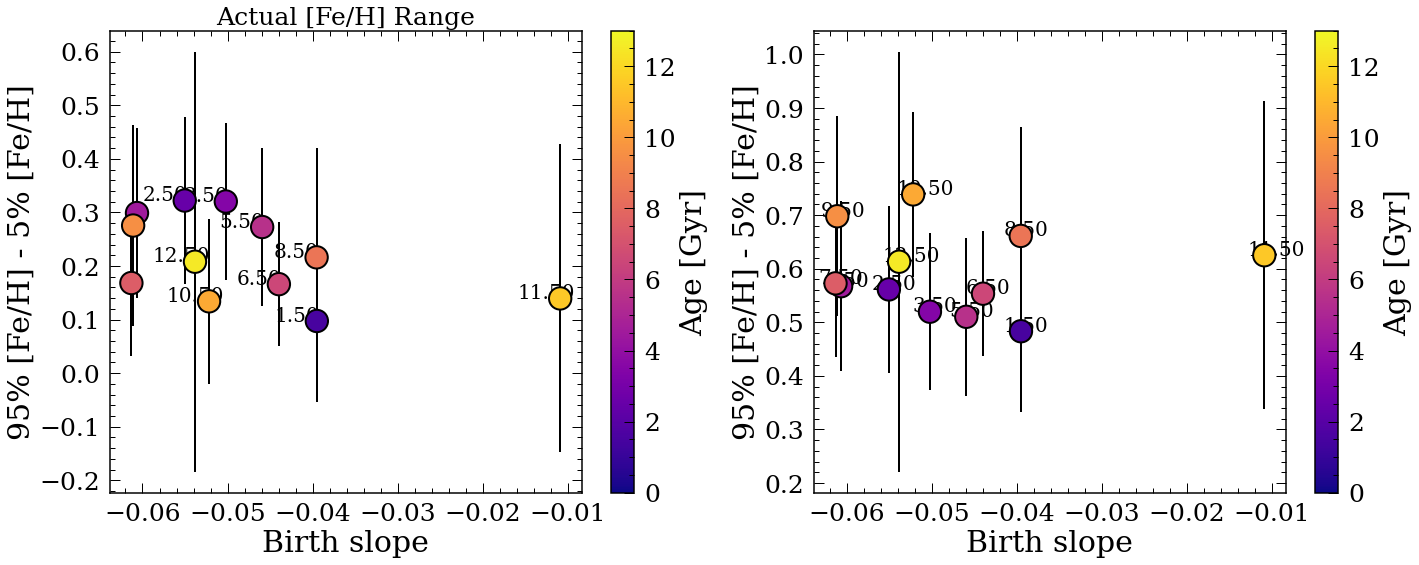

In [341]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.scatter(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]), c=ages[m],
           s=500,  edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]),
             yerr=fehscatter_rbir[m], fmt='ko',
            zorder=1)
plt.xlabel('Birth slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Actual [Fe/H] Range', fontsize=25)
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.005, 
                            (intin(ages[m])-intout(ages[m]))[i]), 
                 fontsize=20,color='k')

plt.subplot(1,2,2)
plt.scatter(slopes_rbir[m], 
         fehscatter[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         fehscatter[m],
             yerr=fehscatter_rbir[m], fmt='ko',
            zorder=1)
plt.xlabel('Birth slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.002, fehscatter[m][i]), 
                 fontsize=20,color='k')
plt.tight_layout()

#plt.title('Data [Fe/H] Range', fontsize=25)


scipy.stats.pearsonr(slopes_rbir[m], (intin(ages[m])-intout(ages[m]))), scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])

((-0.47477119511052, 0.11884206937775438),
 (-0.05116025399931643, 0.8745361557795193))

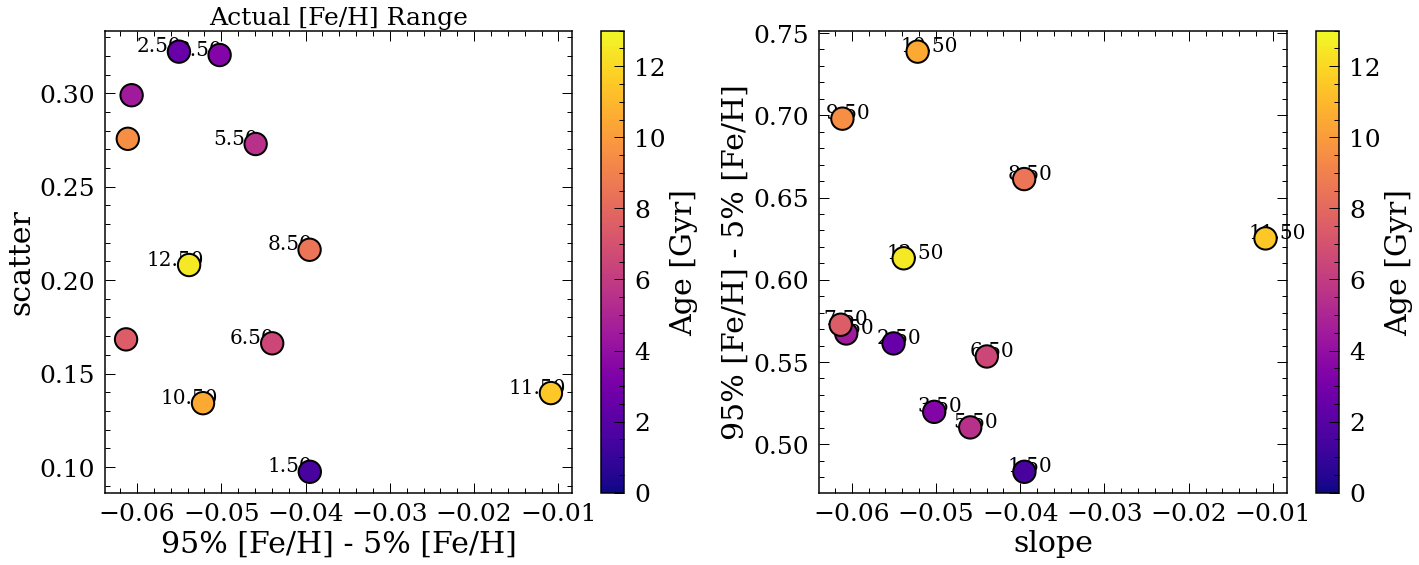

In [342]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.scatter(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]), c=ages[m],
           s=500,  edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.xlabel('95% [Fe/H] - 5% [Fe/H]')
plt.ylabel('scatter')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Actual [Fe/H] Range', fontsize=25)
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.005, 
                            (intin(ages[m])-intout(ages[m]))[i]), 
                 fontsize=20,color='k')

plt.subplot(1,2,2)
plt.scatter(slopes_rbir[m], 
         fehscatter[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.xlabel('slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.002, fehscatter[m][i]), 
                 fontsize=20,color='k')
plt.tight_layout()

#plt.title('Data [Fe/H] Range', fontsize=25)


scipy.stats.pearsonr(slopes_rbir[m], (intin(ages[m])-intout(ages[m]))), scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])